# Pipeline for the anomaly detection on the SKAB using LSTM-based NN

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
# import sys

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [37]:
path_to_data = './data/'

## Data loading

In [38]:
from v1_model_schemes.utils_lstm import load_lstm_dfs
list_of_df = load_lstm_dfs(path_to_data)

In [60]:
list_of_df

[                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
 datetime                                                                        
 2020-03-09 12:14:36           0.027429           0.040353  0.770310  0.382638   
 2020-03-09 12:14:37           0.027269           0.040226  1.096960  0.710565   
 2020-03-09 12:14:38           0.027040           0.039773  1.140150  0.054711   
 2020-03-09 12:14:39           0.027563           0.040313  1.108680 -0.273216   
 2020-03-09 12:14:41           0.026570           0.039566  0.704404  0.382638   
 ...                                ...                ...       ...       ...   
 2020-03-09 12:34:31           0.028051           0.039835  1.061810  0.054711   
 2020-03-09 12:34:32           0.027184           0.039945  1.206770  0.054711   
 2020-03-09 12:34:33           0.027617           0.039430  1.309070  0.054711   
 2020-03-09 12:34:34           0.027669           0.039402  1.303750 -0.273216   
 2020-03-09 12:3

In [39]:
# # benchmark files checking
# all_files=[]
# import os
# for root, dirs, files in os.walk(path_to_data):
#     for file in files:
#         if file.endswith(".csv"):
#              all_files.append(os.path.join(root, file))

In [40]:
# # datasets with anomalies loading
# list_of_df = [pd.read_csv(file, 
#                           sep=';', 
#                           index_col='datetime', 
#                           parse_dates=True) for file in all_files if 'anomaly-free' or 'lgbm_baseline_predictions' not in file]
# # anomaly-free df loading
# anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
#                             sep=';', 
#                             index_col='datetime', 
#                             parse_dates=True)

### Data description

In [41]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1146, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.77031,0.382638,71.2129,25.0827,219.789,32.0,0.0,0.0


### Data visualization

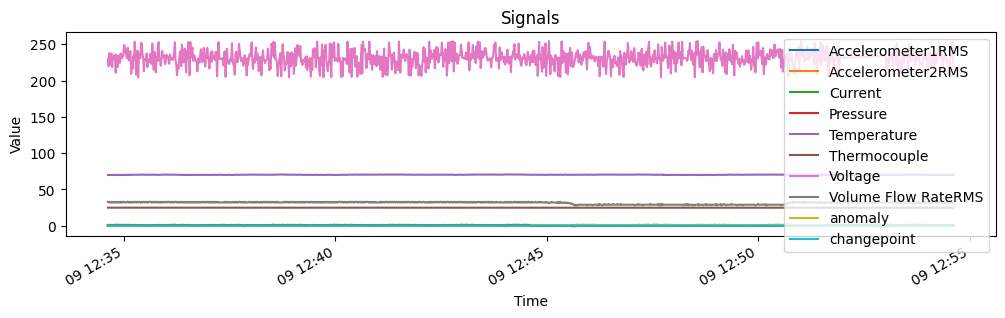

In [42]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

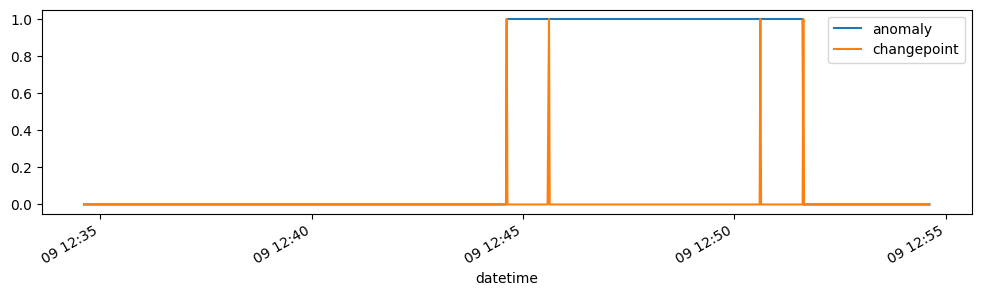

In [43]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method

### Method initialization

In [44]:
# from Vanilla_LSTM import Vanilla_LSTM
import numpy as np
from sklearn.preprocessing import StandardScaler

from model_schemes.lstm import Vanilla_LSTM

In [45]:
# hyperparameters selection
N_STEPS = 5
EPOCHS = 25
BATCH_SIZE = 32
VAL_SPLIT = 0.2
PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
Q = 0.99 # quantile for upper control limit (UCL) selection

In [46]:
# model defining
model = Vanilla_LSTM(PARAMS)

In [47]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Method fitting and applying

In [48]:
predicted_outlier, predicted_cp = [], []

In [49]:
%%time
# inference
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    print("X", X.shape)
    print("y", y.shape)
    
    # model fitting
    model.fit(X, y)
    
    # results predicting
    residuals_train = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 5
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    prediction = pd.Series((lstm_residuals > UCL).astype(int).values, 
                                index=df[N_STEPS:].index).fillna(0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 4ms/step
X (395, 5, 8)
y (395, 8)
35/35 [==============================] - 0s 2ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
35/35 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
34/34 [==============================] - 0s 4ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 3ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 4ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] - 0s 4ms/step
X (395, 5, 8)
y (395, 8)
36/36 [==============================] 

In [50]:
UCL

43.67443721947446

In [51]:
y.shape

(1124, 8)

In [52]:
y.shape

(1124, 8)

In [53]:
predicted_outlier

[datetime
 2020-03-09 12:14:42    0
 2020-03-09 12:14:43    0
 2020-03-09 12:14:44    0
 2020-03-09 12:14:45    0
 2020-03-09 12:14:46    0
                       ..
 2020-03-09 12:34:31    1
 2020-03-09 12:34:32    1
 2020-03-09 12:34:33    1
 2020-03-09 12:34:34    1
 2020-03-09 12:34:35    1
 Length: 1149, dtype: int64,
 datetime
 2020-03-09 12:34:42    0
 2020-03-09 12:34:43    0
 2020-03-09 12:34:44    0
 2020-03-09 12:34:45    0
 2020-03-09 12:34:46    0
                       ..
 2020-03-09 12:54:33    0
 2020-03-09 12:54:34    0
 2020-03-09 12:54:35    0
 2020-03-09 12:54:36    0
 2020-03-09 12:54:37    0
 Length: 1089, dtype: int64,
 datetime
 2020-03-09 11:54:41    0
 2020-03-09 11:54:42    0
 2020-03-09 11:54:43    0
 2020-03-09 11:54:44    0
 2020-03-09 11:54:45    0
                       ..
 2020-03-09 12:14:31    0
 2020-03-09 12:14:32    0
 2020-03-09 12:14:33    0
 2020-03-09 12:14:34    0
 2020-03-09 12:14:35    0
 Length: 1149, dtype: int64,
 datetime
 2020-03-09 11:

### Results visualization

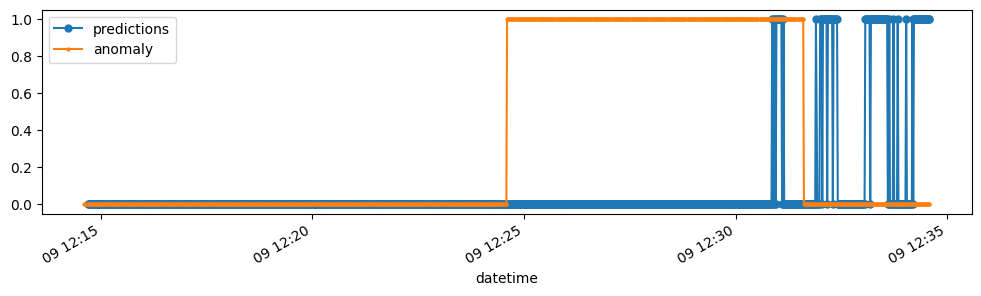

In [54]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

In [55]:
len(true_outlier[0])

1154

In [56]:
len(predicted_outlier[0])

1149

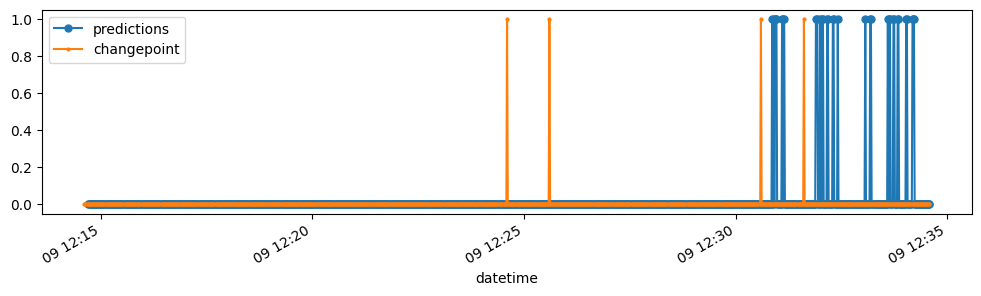

In [57]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()

## Evaluation (metrics calculation)

In [58]:
# 'pip install tsad' if needed
from tsad.utils.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [59]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

False Alarm Rate 5.32 %
Missing Alarm Rate 63.31 %
F1 metric 0.5
